Kaggle Username: Felix Rosenberger

# Introduction

This notebook is for the major project submission for COMP7220/8220, on the [image/language] dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.



# Library and Data Import

In [4]:
# library import
import os
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# notebook setup
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/COMP8220/Major_Project/image-classification')

Mounted at /content/gdrive


In [6]:
# read data in
train = np.load('Data/Training_data_images.npy')
test = np.load('Data/PublicTest_data_images.npy')
labels = np.load('Data/Training_data_labels.npy')

# Basic Data Exploration

Let's first have a look at the different arrays.

In [18]:
# training data
print(f'The training data: \t{train.shape}\n'
      f'The test data: \t\t{test.shape}\n'
      f'The label data: \t{labels.shape}\n')


The training data: 	(9328, 48, 48)
The test data: 		(1136, 48, 48)
The label data: 	(9328,)



We can see that the **training data consists of 9328 images**, each of which is a 48x48 array itself. The image size represents the pixels of each image. Similarly, the test data consists of 1136 images. The label data is vector containing the labels of the 9328 training images. We'll know look at the labels in more detail.

In [21]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

The integers shown are the unique image labels which correspond to emotions displayes on the images. The above order correspond to the labels **[angry, disgusted, fearful, happy, sad, surprised, neutral]**.
Let's look at the first image and corresponding label.

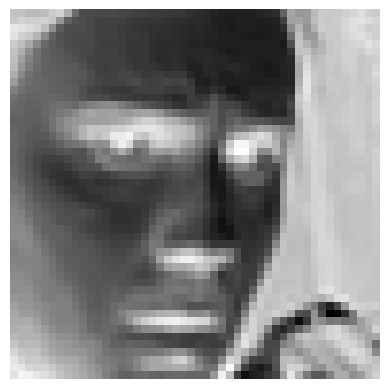

The label for the first image is 0


In [40]:
plt.imshow(train[0], cmap="binary")
plt.axis('off')
plt.show()
print(f'The label for the first image is {labels[0]}')

Hence the above image is classified as 'angry' in the training data. Next we'll look at the range of pixel sizes for each image.

In [45]:
# loop through all images and check min max values
for i in range(len(train)):
  min = np.min(train[i])
  max = np.max(train[i])
  if min < 0 and max > 1:
    print('values out of normalisation range')

We now know that all pixel sizes are between 0 and 1. Hence normalisation is not required at a later stage for preprocessing.

# Data Preprocessing

# Conventional ML Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy x%) was an SVM with a polynomial kernel.  The features were ...

In [ ]:
# some initialisation code

The code below handles feature extraction by first preprocessing the text, and then ...

In [ ]:
# preprocessing + feature extraction code

The model is defined ...

In [ ]:
# model definition code

# Notes on the Conventional ML Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a logistic regression model, ...  This performed fairly poorly (accuracy y%) ...  This may have been because ...

# Deep Learning Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy (x+5)%) was a fully connected dense model with NN layers.  The input was the raw data that had been preprocessed by ...

[Following this, code and comments as above.]

# Notes on the Deep Learning Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a CNN with two conv layers and ...  This performed almost as well as the final model (accuracy (x-3)%) ...  This gap in performance may have been because ...

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning one performed better by 5% on the public test set.  The deep learning model ranked #12 out of N submissions on the public test set, with the top-performing system having z% accuracy, and a majority class baseline having z'% accuracy ...

[E.g. discussion about what performance on validation set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what performance on private test set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what inspecting the data might say about your models or about the dataset.]

[E.g. reflection on resource required for models or other implementation issues.]

